In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive')

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, recall_score, precision_score, f1_score

In [ ]:
data_dir = '/content/drive/MyDrive/Object-CXR/DATA_DIR'
test_dir = os.path.join(data_dir, 'test')
print(test_dir)

/content/drive/MyDrive/Object-CXR/DATA_DIR/test


In [ ]:
labels_test = pd.read_csv(data_dir + '/test.csv', na_filter=False)

In [ ]:
# original download test.csv file had /test/ infront of all image names this box
# is used to change this to just the image name

image_list = []

for i in range(1000):
  image_string = labels_test.image_path[i][5:]
  image_list.append(image_string)


test_reformatted = pd.DataFrame({'image_name': image_list, 'annotation': labels_test.annotation})

test_reformatted.to_csv(data_dir + '/test_reformatted.csv',columns=['image_name', 'annotation'], sep=',', index=None)

# ─── DATA_DIR
#     ├── train
#     │   ├── #####.jpg
#     │   └── ...
#     ├── dev
#     │   ├── #####.jpg
#     │   └── ...
#     ├── test
#     │   ├── #####.jpg
#     │   ├── ...
#     ├── train.csv
#     ├── dev.csv          
#     ├── test.csv
#     └── test_reformatted.csv

# Build Dataset

In [ ]:
class ObjectDataset(Dataset):
    """
    Creates a Dataset object of the images and their corresponding labels.
    """

    def __init__(self, csv_file, root_dir, transform=None):
        """
        :param csv_file (string): Path to the csv file with annotations
        :param root_dir (string): Directory with all the images
        :param transform (callable, optional): Optional transform to be applied on a sample
        """
        self.frame = pd.read_csv(csv_file, na_filter=False)
        self.root_dir = root_dir
        self.transform = transform
        # Renaming the 'annotation' column and calling it 'label'
        self.frame = self.frame.rename(columns={"annotation": "label"})
        # Now we change the content of the label column
        # If content is empty i.e. "", then label it 0
        # Otherwise, label it 1
        num_index = range(len(self.frame))
        for idx in num_index:
            label = self.frame.loc[idx, 'label']
            if label == "":
                self.frame.loc[idx, 'label'] = 0
            else:
                self.frame.loc[idx, 'label'] = 1

    def __len__(self):
        return len(self.frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.frame.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")  # convert image to RGB

        replaced_label = self.frame.loc[idx, "label"]

        # Applying transforms
        if self.transform:
            for tsfrm in self.transform:
                image = tsfrm(image)

        sample = {"image": image, "label": replaced_label}
        return sample

In [ ]:
img_transforms_test = [transforms.Compose([transforms.Resize((800, 800))]),
                       transforms.Compose([transforms.ToTensor()]),
                       transforms.Compose([transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])])
                       ]

print("Initialising Datasets and Dataloaders...")
test_dataset = ObjectDataset(csv_file=data_dir + '/test_reformatted.csv',
                             root_dir=test_dir,
                             transform=img_transforms_test)
test_dataLoader = DataLoader(test_dataset, batch_size=1, shuffle=False,
                             num_workers=4)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

Initialising Datasets and Dataloaders...


# Loading Best Model

In [ ]:
def initialise_inception_v3(num_classes, input_size, use_pretrained=True):
    """
    This function initialises an Inception v3 model.

    :param num_classes: The number of classes your Inception v3 model outputs.
    :param input_size: The size of your image as a single value. For example,
                       if image size is (800, 800), input_size=800.
    :param use_pretrained: If True, returns a model pre-trained on ImageNet.

    :return: the inception v3 model, its input size
    """

    model_ft = models.inception_v3(pretrained=use_pretrained)
    # Handle the auxiliary net
    num_ftrs = model_ft.AuxLogits.fc.in_features
    model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
    # Handle the primary net
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    input_size = input_size

    return model_ft, input_size

In [ ]:
def load_best_model(best_model_path, model):
  """
  This function loads the states of the best trained inception v3 model.

  :param best_model_path: The path where the best model is stored
  :param model: The initialised inception v3 model

  :return: The trained model with the states loaded
  """
  load_checkpoint = torch.load(best_model_path, map_location="cuda:0")
  model.load_state_dict(load_checkpoint['state_dict'])
  return model

In [ ]:
model, input_size = initialise_inception_v3(num_classes=2, input_size=800,
                                            use_pretrained=True)
model.to(device)

# Load the trained states of the inception v3 model
best_model_path = '/content/drive/MyDrive/Object-CXR/MODEL_DIR/best_model.pt'
trained_inception_v3_model = load_best_model(best_model_path, model)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


# Inference

In [ ]:
# Inference
with torch.no_grad():
  trained_inception_v3_model.eval()

  preds_prob = []
  labels = []
  locs = []

  for data in test_dataLoader:
    input, label = data.get('image'), data.get('label')
    input, label = input.to(device), label.to(device)

    labels.append(label[-1])

    output = trained_inception_v3_model(input)
    output = torch.nn.Softmax(dim=1)(output)

    preds_prob.append(output[0][1])

preds_prob = torch.Tensor(preds_prob)
preds_prob = preds_prob.tolist()

In [ ]:
pred = []
for i in range(len(preds_prob)):
  if (preds_prob[i] >= 0.5):
    pred.append(1)
  else:
    pred.append(0)

# Inference Performance Visualisation

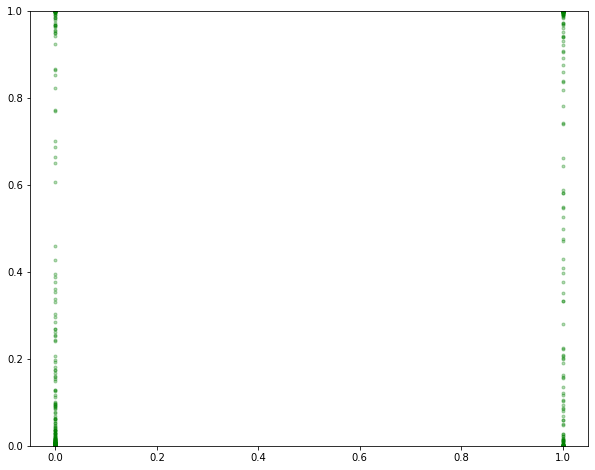

In [ ]:
gt = labels_test.annotation.astype(bool).astype(float).values

plt.figure(figsize=(10, 8))
plt.plot(gt, preds_prob, '.', color="green", alpha=0.3)
plt.ylim((0, 1))

image_dir = '/content/drive/MyDrive/Object-CXR/Images'
plt.savefig(f"{image_dir}/prediction_concentration_graph.png")

In [ ]:
acc = (pred == gt).mean()
fpr, tpr, _ = roc_curve(gt, preds_prob)
roc_auc = auc(fpr, tpr)

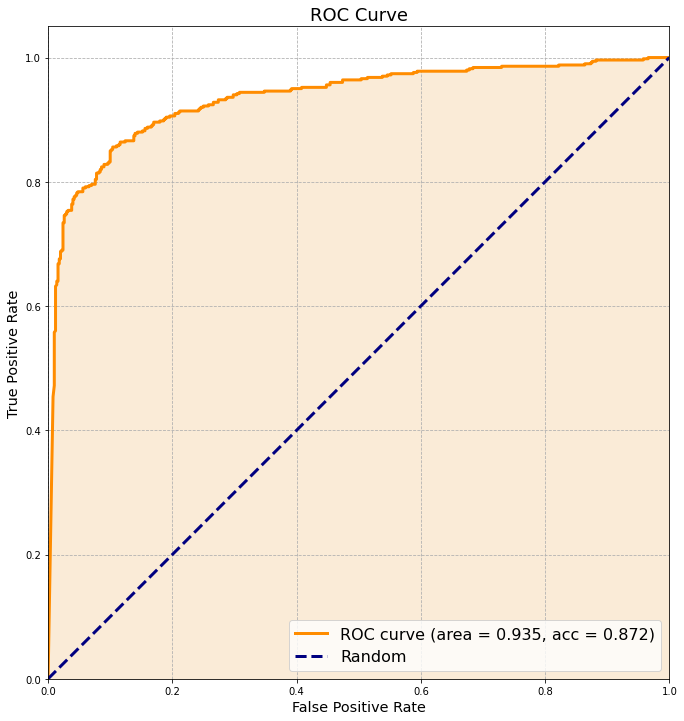

In [ ]:
# Plotting the ROC Curve
fig, ax = plt.subplots(
    subplot_kw=dict(xlim=[0, 1], ylim=[0, 1.05], aspect='equal'),
    figsize=(12, 12)
)
ax.plot(fpr, tpr, lw=3, color='darkorange',
        label=f"ROC curve (area = {roc_auc:.03}, acc = {acc:.03})")
ax.plot([0, 1], [0, 1], '--', lw=3,
        color='navy', label='Random')
plt.xlabel("False Positive Rate", fontsize="x-large")
plt.ylabel("True Positive Rate", fontsize="x-large")
plt.fill_between(fpr, tpr, color="antiquewhite")
_ = ax.legend(loc="lower right", fontsize=16)
_ = ax.set_title("ROC Curve", fontsize=18)
ax.grid(linestyle="dashed")

plt.savefig(f"{image_dir}/ROC_curve.png")

In [ ]:
# Plotting the confusion matrix
gt_list = [int(i) for i in gt.tolist()]
cfm = confusion_matrix(gt_list, pred)
cfm

array([[450,  50],
       [ 78, 422]])

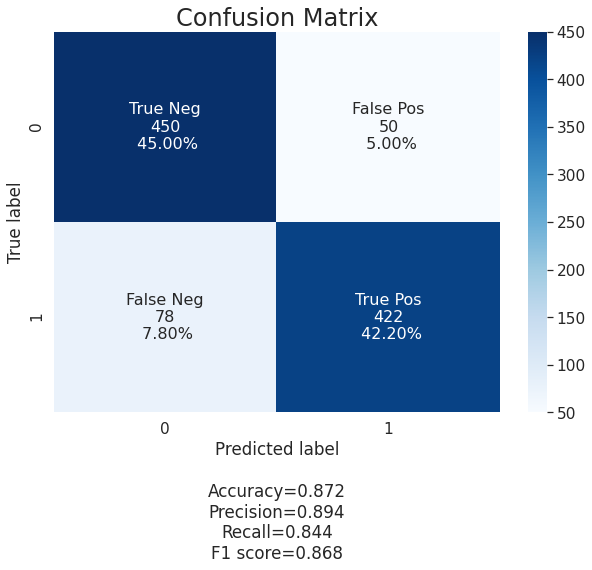

In [ ]:
precision = round(precision_score(gt_list, pred), 3)
recall = round(recall_score(gt_list, pred), 3)
f1 = round(f1_score(gt_list, pred), 3)

plt.figure(figsize=(10,7))
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cfm.flatten()]
group_percentages = ["{0: .2%}".format(value) for value in cfm.flatten()/np.sum(cfm)]

heatmap_labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
heatmap_labels = np.asarray(heatmap_labels).reshape(2, 2)

sn.set(font_scale=1.4) # for label size
sn.heatmap(cfm, annot=heatmap_labels, annot_kws={"size": 16},
           cmap="Blues", fmt="")

plt.title("Confusion Matrix", fontsize=24)
plt.xlabel(f"Predicted label\n\nAccuracy={acc}\nPrecision={precision}\nRecall={recall}\nF1 score={f1}")
plt.ylabel("True label")

plt.savefig(f"{image_dir}/confusion_matrix.png", bbox_inches="tight")
plt.show()

